# Document Classification with Word Embeddings

In this previous activity, we have enough fun playinng around the word embeddings. 
Now, we get to the stage that we will make real use of them, i.e., we are going to build on these embeddings machine learing models for document classification. 😊


## The Dataset
Same as in the previous activity, the document collection that we are going to use is the BBC News Dataset. For the origin of the dataset, please refer to [here](http://mlg.ucd.ie/datasets/bbc.html)
To be brief, the dataset consists of 2225 documents from the BBC news website corresponding to stories in five topical areas, i.e., class Labels (business, entertainment, politics, sport, tech).

In this activity, instead of using the raw dataset, we will utilised the pre-processed clean dataset we saved in our previous Activity 3 Generating Feature Vectors.
Recall that at the end of Activity 3, we saved the pre-processed articles in a txt file named `bbcNews.txt`, where, each row is a document, with tokens seperated by whitespace.

Before continue, please make sure you have the following files in the same folder as this jupyter notebook:
* `bbcNews.txt`: contains the pre-process BBC news articles
* `labels.csv`: contains the label/class of each article.

In [20]:
from itertools import chain
from nltk.probability import *
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# import code as a function
from src.utils import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# logging for event tracking
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Let's read in the labels and article data, and construct a single dataframe to store them correspondingly. 
Note that the order of the articles are the same as the labels data, as they are all in sorted order of document names. 

In [3]:
# Read job_ad.csv
job_ad = pd.read_csv('job_ad.csv')

# # get the description of the job ad
# description = job_ad['Description']
# # get the tokenized description of the job ad
# tk_description = job_ad['Tokenized Description']
webindex = job_ad['Webindex']


# print first 3 rows
job_ad.head(3)

,Title,Webindex,Company,Description,Tokenized Description,Category
0,<function title at 0x7fd51155e670>,68997528,First Recruitment Services,Accountant (partqualified) to **** p.a. South ...,"['accountant', 'partqualified', 'south', 'east...",Accounting_Finance
1,<function title at 0x7fd51155e670>,68063513,Austin Andrew Ltd,One of the leading Hedge Funds in London is cu...,"['leading', 'hedge', 'funds', 'london', 'recru...",Accounting_Finance
2,<function title at 0x7fd51155e670>,68700336,Caritas,An exciting opportunity has arisen to join an ...,"['exciting', 'opportunity', 'arisen', 'join', ...",Healthcare_Nursing


Read in the article text, and creates another list to store the tokenized version of the article text accordingly.

In [4]:
descriptionFile = './description.txt'
with open(descriptionFile) as txtf:
    description_txts = txtf.read().splitlines() # reading a list of strings, each for a document/article
tk_description = [a.split(' ') for a in description_txts]

Store the article text (as well as the tokenized version) to the dataframe.

In [5]:
job_ad['Description'] = description_txts

In [6]:
job_ad['Tokenized Description'] = tk_description

In [7]:
job_ad.sample(n = 5) # look at a few examples

,Title,Webindex,Company,Description,Tokenized Description,Category
479,<function title at 0x7fd51155e670>,71186393,Q Personnel Employment Services,working partnership large number equipment man...,"[working, partnership, large, number, equipmen...",Engineering
328,<function title at 0x7fd51155e670>,70623750,Green Care Management,staff nurse newly qualified considered stevena...,"[staff, nurse, newly, qualified, considered, s...",Healthcare_Nursing
729,<function title at 0x7fd51155e670>,68537749,MSI Nurses LTD,msi nurses recruit qualified experienced regis...,"[msi, nurses, recruit, qualified, experienced,...",Healthcare_Nursing
650,<function title at 0x7fd51155e670>,69564390,Mason Blake Ltd,newly created position involve daily interacti...,"[newly, created, position, involve, daily, int...",Accounting_Finance
743,<function title at 0x7fd51155e670>,72691163,Finlay James Associates Limited,amazing role years sales experience preferably...,"[amazing, role, years, sales, experience, pref...",Sales


In the previous activity, we ahve explore a few language models and word embedings, including: 

Pre-trained embeddigns:
- `preTW2v_wv`: Word2Vec embeddings pre-trained from Google news 300 dataset
- `preTGloVe_wv`: pre-trained GloVe embeddings 

Embeddings trained on the BBC News data:
- `bbcW2v_wv`
- `bbcFT_wv`

In this activity, we are going to use them for document classification. 
Before we use, we will need to load them in this activity notebook one by one, and for each, we will need to construct the document representation, i.e., document embeddings based on the word embeddings.


0 null record  😊

### 1.1 Understand your task by tSNE

Alright! so we have the document embedding vector representation for each article now, we can proceed to the task of document classification. 
Before, we move on, a good habbit is to explore and understand how difficult the task is, whether there are too much noise in the data, making it impossible to clearly separate each category. 

One way to confirm that the feature space we are using is representative enough for our task (classifying articles into separate labels) to be solvable is to use dimensionality-reduction techniques: These methods project a high-dimensional vector into a lower number of dimensions, with different guarantees on this projection according to the method used. 
In this activity, we will use [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), a popular dimensionality reduction technique used in many fields, including NLP.

Since we will do the same thing again and again when we try other embeddings, we will construct a function to do this again.
The following function `plotTSNE` takes the following arugments:
* labels, the lable/category of each article
* features, a numpy array of document embeddings, each for an article.

and projects the feature/document embedding vectors in a 2 dimension space and plot them out. 
It does the following:
1. get the set of classes, called `categories` (5 categories)
2. sample 30% of the data/document embeddings randomly, and record the indices selected
3. project the selected document embeddings in 2 dimensional space using tSNE, each document embedding now corresponds to a 2 dimensional vector in `projected_features`
4. plot them out as scatter plot and highlight different categories in different color

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
def plotTSNE(labels,features): # features as a numpy array, each element of the array is the document embedding of an article
    categories = sorted(labels.unique())
    # Sampling a subset of our dataset because t-SNE is computationally expensive
    SAMPLE_SIZE = int(len(features) * 0.3)
    np.random.seed(0)
    indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)
    projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices])
    colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']
    for i in range(0,len(categories)):
        points = projected_features[(labels[indices] == categories[i])]
        plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[i], label=categories[i])
    plt.title("Feature vector for each article, projected on 2 dimensions.",
              fontdict=dict(fontsize=15))
    plt.legend()
    plt.show()

In [9]:
features = preTW2v_dvs.to_numpy() # convert the document vector dataframe to a numpy array
plotTSNE(job_ad['Category'],features) # plot the tSNE to have a look

Oh! Not bad, there are a bit of noises, but overall, seems an easy one, the different categories are quite nicely seperated! Well~ if you remember this dataset prevoiusly, you would have a rough idea anyway, with the binary/count/tfijob_ad vector representation, we have accuracy above 95% 😊
Ok, now, let's move on to the serious task: Document Classfication

## 3. FastText model trained on BBC News data

Finally, we experiment the FastText embeddings. 
Similar, we:
* load the FastText model saved in our prevoius activity;
* generate document embeddings based on the load FastText word embeddings;
* explore the reprensentiveness of the features through tSNE;
* bulid the logistic regression model based on the generated document embeddings for news classfication.

In [10]:
# loading the trained Fasttext model based on bbc News data
from gensim.models.fasttext import FastText
bbcFT = FastText.load("bbcFT.model")
print(bbcFT)
bbcFT_wv= bbcFT.wv

2022-10-01 21:45:18,909 : INFO : loading FastText object from bbcFT.model
2022-10-01 21:45:18,915 : INFO : loading wv recursively from bbcFT.model.wv.* with mmap=None
2022-10-01 21:45:18,915 : INFO : loading vectors_ngrams from bbcFT.model.wv.vectors_ngrams.npy with mmap=None
2022-10-01 21:45:19,134 : INFO : setting ignored attribute buckets_word to None
2022-10-01 21:45:19,135 : INFO : setting ignored attribute vectors to None
2022-10-01 21:45:19,650 : INFO : setting ignored attribute cum_table to None
2022-10-01 21:45:19,738 : INFO : FastText lifecycle event {'fname': 'bbcFT.model', 'datetime': '2022-10-01T21:45:19.738783', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  5 2022, 01:53:17) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'loaded'}


FastText<vocab=10485, vector_size=100, alpha=0.025>


In [11]:
# NOTE this can take some time to finish running
# generate document embeddings
bbcFT_dvs = gen_docVecs(bbcFT_wv,job_ad['Tokenized Description'])
bbcFT_dvs.isna().any().sum()

0

/Users/tnathu-ai/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/tnathu-ai/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


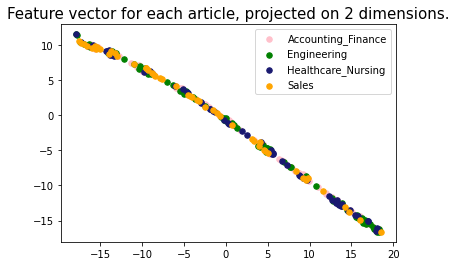

In [13]:
# explore feature space
features = bbcFT_dvs.to_numpy()
plotTSNE(job_ad['Category'],features)

er~~~ for some categories seems a bit messy also.....

In [27]:
# build the classfication model and report results
seed = 3879312
X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(bbcFT_dvs, job_ad['Category'], list(range(0,len(job_ad))),test_size=0.33, random_state=seed)

model = LogisticRegression(max_iter = 1000,random_state=seed)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.311284046692607

## 4. Generating TF-Ijob_ad weighted document vectors

Ok, I hope you have lots of fun building document embeddings based on varoius word embedding models. 
Previously, when we generate the document embeddings, we just sum up the embeddings vector of each tokenized word in the article, a bit simplicity 🤔

In this section, let's make it a bit more challenging, we are going to build the tf-ijob_ad document embeddings. 
What does that mean? 🤨
Hmm~~ it's not magic, we just do a weigthed sum of the word embedding vectors, however, the weight here, refers to the tf-ijob_ad weight of the word. 

If you already forgot about what is `tf-ijob_ad`, please refer to Activity 3 Pre-processing Text and Generating Features. 
Otherwise, move on!
So we've generated the tf-ijob_ad vector representation of documents in Activity 3 and saved in a txt file called `bbcNews_tVector.txt`. The format of this file is:
- each line represents an article;
- each line is of the format 'w_index:weight w_index:weight ......' 

Oh, but we don't have that word index `w_index` here in this activity, what should we do? 🤔
ah ha, we also saved the vocabulary in a file `vocab`, in which each line is a word, and of the format `index,word`. 
Theresore, based on these two files, we can create a word:weight mapping for each tokenized word in a document!

Ok, in the following couple block of codes, this is exactly what we are trying to do, step by step. 
- the `gen_vocIndex` function reads the the vocabulary file, and create an w_index:word dictionary

In [29]:
def read_vocab(vocab_file):
    vocab = {}
    with open(vocab_file) as f:
        for line in f:
            (word, index) = line.split(':')
            vocab[word.strip()] = int(index)
    return vocab

# Generates the w_index:word dictionary
voc_fname = 'vocab.txt'
voc_dict = read_vocab(voc_fname)
voc_dict

{'aap': 0,
 'aaron': 1,
 'aat': 2,
 'abb': 3,
 'abenefit': 4,
 'aberdeen': 5,
 'abi': 6,
 'abilities': 7,
 'ability': 8,
 'abreast': 9,
 'abroad': 10,
 'absence': 11,
 'absolute': 12,
 'ac': 13,
 'aca': 14,
 'academic': 15,
 'academy': 16,
 'acca': 17,
 'accept': 18,
 'acceptable': 19,
 'acceptance': 20,
 'accepted': 21,
 'access': 22,
 'accessible': 23,
 'accident': 24,
 'accommodates': 25,
 'accommodation': 26,
 'accomplished': 27,
 'accordance': 28,
 'account': 29,
 'accountabilities': 30,
 'accountability': 31,
 'accountable': 32,
 'accountancy': 33,
 'accountant': 34,
 'accountants': 35,
 'accounting': 36,
 'accounts': 37,
 'accreditation': 38,
 'accredited': 39,
 'accruals': 40,
 'accuracy': 41,
 'accurate': 42,
 'accurately': 43,
 'achievable': 44,
 'achieve': 45,
 'achieved': 46,
 'achievement': 47,
 'achievements': 48,
 'achiever': 49,
 'achieving': 50,
 'acii': 51,
 'acquired': 52,
 'acquisition': 53,
 'acquisitions': 54,
 'act': 55,
 'acting': 56,
 'action': 57,
 'actions': 

- the `doc_wordweights` function takes the tfijob_ad document vector file, as well as the w_index:word dictionary, creates the mapping between w_index and the actual word, and creates a dictionary of word:weight or each unique word appear in the document.

In [33]:
def doc_wordweights(fName_tVectors, voc_dict):
    tfijob_ad_weights = [] # a list to store the  word:weight dictionaries of documents
    
    with open(fName_tVectors) as tVecf: 
        tVectors = tVecf.read().splitlines() # each line is a tfijob_ad vector representation of a document in string format 'word_index:weight word_index:weight .......'
    for tv in tVectors: # for each tfijob_ad document vector
        tv = tv.strip()
        weights = tv.split(' ') # list of 'word_index:weight' entries
        weights = [w.split(':') for w in weights] # change the format of weight to a list of '[word_index,weight]' entries
        wordweight_dict = {voc_dict[int(w[0])]:w[1] for w in weights} # construct the weight dictionary, where each entry is 'word:weight'
        tfijob_ad_weights.append(wordweight_dict) 
    return tfijob_ad_weights

fName_tVectors = 'jobAd_tVector.txt'
tfijob_ad_weights = doc_wordweights(fName_tVectors, voc_dict)

KeyError: 4759

In [34]:
# take a look at the tfijob_ad word weights dictionary of the first document
tfijob_ad_weights[0]

NameError: name 'tfijob_ad_weights' is not defined

Ok, once we have the word:weight dictionary of each document, now we can construct the tf-ijob_ad weighted document embeddings. 
* the following `gen_docVecs` function is an revision/extension of the previous written function, that takes the word embeddings dictionary, the tokenized text of articles, and the tfijob_ad weights (list of word:weight dictionaries, one for each article) as arguments, and generates the document embeddings:
 1. creates an empty dataframe `docs_vectors` to store the document embeddings of articles
  2. it loop through every tokenized text:
    - creates an empty dataframe `temp` to store all the word embeddings of the article
    - for each word that exists in the word embeddings dictionary/keyedvectors, 
        - if the argument `tfijob_ad` weights are empty `[]`, it sets the weight of the word as 1
        - otherwise, retrieve the weight of the word from the corresponding word:weight dictionary of the article from  `tfijob_ad`
    - row bind the weighted word embedding to `temp`
    - takes the sum of each column to create the document vector, i.e., the embedding of an article
    - append the created document vector to the list of document vectors

In [ ]:
# extended version of the `gen_docVecs` function
def gen_docVecs(wv,tk_txts,tfijob_ad = []): # generate vector representation for documents
    docs_vectors = pd.DataFrame() # creating empty final dataframe
    #stopwords = nltk.corpus.stopwords.words('english') # removing stop words

    for i in range(0,len(tk_txts)):
        tokens = list(set(tk_txts[i])) # get the list of distinct words of the document

        temp = pd.DataFrame()  # creating a temporary dataframe(store value for 1st doc & for 2nd doc remove the details of 1st & proced through 2nd and so on..)
        for w_ind in range(0, len(tokens)): # looping through each word of a single document and spliting through space
            try:
                word = tokens[w_ind]
                word_vec = wv[word] # if word is present in embeddings(goole provides weights associate with words(300)) then proceed
                
                if tfijob_ad != []:
                    word_weight = float(tfijob_ad[i][word])
                else:
                    word_weight = 1
                temp = temp.append(pd.Series(word_vec*word_weight), ignore_index = True) # if word is present then append it to temporary dataframe
            except:
                pass
        doc_vector = temp.sum() # take the sum of each column(w0, w1, w2,........w300)
        docs_vectors = docs_vectors.append(doc_vector, ignore_index = True) # append each document value to the final dataframe
    return docs_vectors

Ok we now have everything ready to generate the weight document embeddings. 
We can do this on any of our previous explored models, including the pretrained Word2Vec GoogleNews300, Glove, our in-house trained Word2Vec and FastText.

Let's generated the weighted version of the document embedding vectors first

In [ ]:
weighted_preTW2v_dvs = gen_docVecs(preTW2v_wv,job_ad['Tokenized Description'],tfijob_ad_weights)
weighted_preTGloVe_dvs = gen_docVecs(preTGloVe_wv,job_ad['Tokenized Description'],tfijob_ad_weights)
weighted_bbcW2v_dvs = gen_docVecs(bbcW2v_wv,job_ad['Tokenized Description'],tfijob_ad_weights)
weighted_bbcFT_dvs = gen_docVecs(bbcFT_wv,job_ad['Tokenized Description'],tfijob_ad_weights)

And we can do very much the same thing as what we do before for other models. 
Here, we will do this as loops, for each model:
- we plot out the feature vectors  projected in a 2-dimensional space,then 
- we build the logistic regression model for document classfication and report the model performance.

In [ ]:
%matplotlib inline
seed = 0
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

models = [weighted_preTW2v_dvs,weighted_preTGloVe_dvs,weighted_bbcW2v_dvs,weighted_bbcFT_dvs]
model_names = ["Weighted Pretrained Word2Vec", "Weighted Pretrained GloVe", "Weighted In-house Word2Vec","Weighted In-house FastText"]
for i in range(0,len(models)): #loop through each model
    dv = models[i]
    name = model_names[i]
    features = dv.to_numpy() # convert the dataframe stored features to an numpy array
    print(name + ": tSNE 2 dimensional projected Feature space")
    plotTSNE(job_ad['Category'],features)
    
    # creating training and test split
    X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(dv, job_ad['Category'], list(range(0,len(job_ad))),test_size=0.33, random_state=seed)

    model = LogisticRegression(max_iter = 2000,random_state=seed)
    model.fit(X_train, y_train)
    print("Accuracy: ", model.score(X_test, y_test))
    print('\n\n')

#### Note: Creating tfijob_ad weighted document embeddings using Gensim

In the previous sections, we tried very hard to create the tfijob_ad weighted document embeddings using the generated tf-ijob_ad weights save in previous activity. 
Indeed, we can using Genism to do this direction, and it's indeed, a bit less effor required 😑 Will show you below. 
We will use the in-house build Word2Vec model as an example.

In [ ]:
from gensim.corpora import Dictionary
from gensim.models.tfijob_admodel import Tfijob_adModel

# we have two vocabularies here, one from the in-house bulit Word2Vec, the other from the articles 
# note that althought the Word2Vec is built on the same dataset, but they might have done further 
# pre-processing during model build (e.g., setting min_count), and thus, might create mismatch in the two vocabularis. 
# therefore, we remove tokenized words that doesn't exist in the keyedvectors in the Word2Vec keyedvectors
processed_text = [[w for w in t if w in bbcW2v_wv.index_to_key] for t in job_ad['Tokenized Description']] 

# use the Gensim package to create a dictionary that encapsulates the mapping between normalized words and their integer ids.
docs_dict = Dictionary(processed_text) # creates a dictionary from the text
docs_dict.filter_extremes(no_below=5) # filtering words that appear less than 5 times
docs_dict.compactify() # assign new word ids to all words, shrinking any gaps.

In [ ]:
# see what are the words that been get rid off when we do the fliter
[w for w in bbcW2v_wv.index_to_key if w not in docs_dict.values()]

In [ ]:
len(docs_dict.keys())

This process yields a vocabulary with 8647 words. 
Then we use Gensim again to create a bag-of-words representation of each document, i.e., the TF-Ijob_ad vector for each document.


In [ ]:
import numpy as np
from gensim.matutils import sparse2full

docs_corpus = [docs_dict.doc2bow(doc) for doc in job_ad['Tokenized Description']] # convert corpus to Bag of Word format
model_tfijob_ad = Tfijob_adModel(docs_corpus, id2word=docs_dict) # fit the tfijob_ad model
# apply model to the list of corpus document, 
# so each document is a list of tuples, (word_index, weight) for each word appears in the document
docs_tfijob_ad  = model_tfijob_ad[docs_corpus]

In [ ]:
# see for example, the tfijob_ad weights of the words in the 2nd document
docs_tfijob_ad[1]

We can then transfer `docs_tfijob_ad` to matrix form. `vstack` function from numpy can stack arrays in sequence vertically (row wise), and `sparse2full` function convert a document in sparse document format (in size of the number of words in the document) into a dense numpy array (of size of the vocabulary)

In [ ]:
docs_vecs   = np.vstack([sparse2full(c, len(docs_dict)) for c in docs_tfijob_ad])

In [ ]:
docs_vecs.shape

In [ ]:
docs_vecs[0]

The result, `docs_vecs`, is a matrix with 2225 rows (docs) and 8647 columns (TF-Ijob_ad terms). 

Let's see the performance of this TF-Ijob_ad vector:

In [ ]:
# creating training and test split
X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(docs_vecs, job_ad['Category'], list(range(0,len(job_ad))),test_size=0.33, random_state=seed)

model = LogisticRegression(max_iter = 1000,random_state=seed)
model.fit(X_train, y_train)
model.score(X_test, y_test)

Wow~ quite good!

Now try to use this tfijob_ad vector to create the weighted document embeddings.

Be careful, the vocabulary are different, for instance, 

In [ ]:
# see how many words are encoded in our in-house Word2Vec model?
len(bbcW2v_wv.index_to_key)

In [ ]:
# how about the tfijob_ad vector?
len(docs_dict)

We only care about words that are in both vocabulary. 
In the following, we creates the word embeddings arrays for words exists in docs_dict

In [ ]:
word_emb_vecs = np.vstack([bbcW2v_wv[docs_dict[i]] for i in range(len(docs_dict)) if docs_dict[i] in bbcW2v_wv.index_to_key])

In [ ]:
word_emb_vecs.shape

In [ ]:
word_emb_vecs[0]

Now we can do the dot product of the two vectors and get our tfijob_ad weighted document embeddings:

In [ ]:
tfijob_ad_docs_emb = np.dot(docs_vecs, word_emb_vecs) 

In [ ]:
# creating training and test split
X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(tfijob_ad_docs_emb, job_ad['Category'], list(range(0,len(job_ad))),test_size=0.33, random_state=seed)

model = LogisticRegression(max_iter = 1000,random_state=seed)
model.fit(X_train, y_train)
model.score(X_test, y_test)

Not much difference from the one we did ourselves (refer to the performance of the `Weighted In-house Word2Vec`.
Comparing the performance of the tfijob_ad weighted document emeddings with our in-house built Word2Vec and the non-weighted on (referring to Section 2), adding the tfijob_ad weight indeed worsen the results in this example. 
Indeed, in this example, the most simply bag-of-word tfijob_ad vector representatino words much better, i.e., 0.978 accuracy 😆

> **Discussion**
Does adding the tfijob_ad weight to construct document embedding and/or having a more complicated model guarantees higher performance?


Cool! 🤩 It gets the right class (I hope you got the same, but maybe you have different results....)
Try as many as you want and have fun! 😊

If you run the infer_vecotr multiple time, every time you get a different vector. and thus, when you predict the class based on the different document vectors, you may get different results. 🤪 🤪 🤪 
Refer to the answer of the [this question](https://github.com/RaRe-Technologies/gensim/wiki/recipes-&-faq#q12-ive-used-doc2vec-infer_vector-on-a-single-text-but-the-resulting-vector-is-different-each-time-is-there-a-bug-or-have-i-made-a-mistake-doc2vec-inference-non-determinism) to understand why. 


## Summary

Phew~~ this is a big activity. I got exhausted written it up and I believe you got a bit exhaused looking through it too 🤣
Give yourself a clap! Well done! 👏👏👏



## Exericse:
Ok, we leave a few exercises for you:
- We have try vector size 100 so far, but there are many alternatives, e.g., 50,200,300. Try other size and report performance. Discuss and share your thoughts with your peers: does larger vector size guarantees better performance?
- So far, in this activities, we have been using the cleaned articles. Many of these libraries (including Genism) has included functionalities to do simply cleaning of text. Try them on and compare the performance.
- Oh, one other very important thing. The results we presented so for in this activity, are based on a single run. To report more robust results, you should do Cross validation. Implement cross validation on the models we explore in this activity, and do a comprehensive comparsion on them.
    


## References
[1] [TFIjob_ad with Word Embeddings](https://github.com/ytnvj2/DocumentEmbedding/blob/master/TFIjob_adwithEmbeddings.ipynb)  
[2] [Problem-solving with ML: automatic document classification](https://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classification)     
[3] [Creating TF-Ijob_ad Weighted Word Embeddings](http://dsgeek.com/2018/02/19/tfijob_ad_vectors.html)    